In [185]:
import numpy as np
import pandas as pd
from numpy.linalg import inv

df = pd.read_csv("./california_housing_train.csv")
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

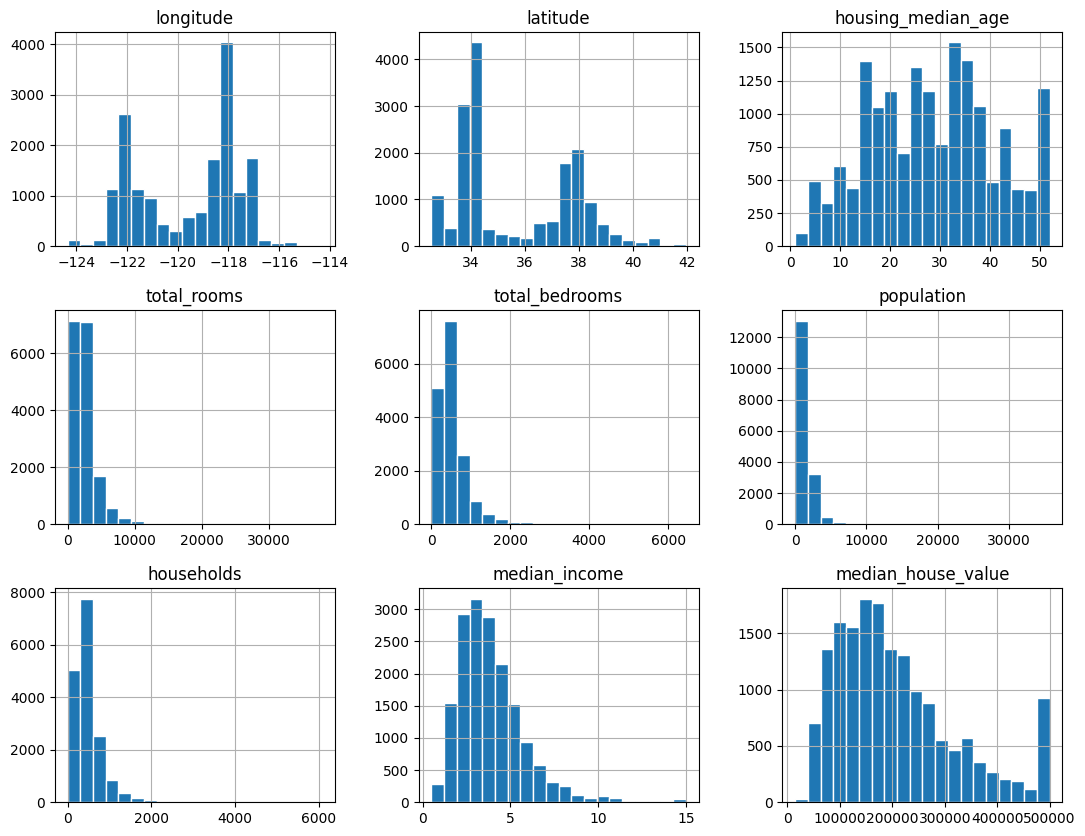

In [166]:
df.hist(figsize=(13, 10), bins=20, edgecolor="white")

Проверка на наличие пустых ячеек

In [167]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

Нормализация данных

In [168]:
normalized_df = (df - df.min()) / (df.max() - df.min())
y = normalized_df["median_house_value"].values
x = normalized_df.drop(columns=["median_house_value"]).values

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

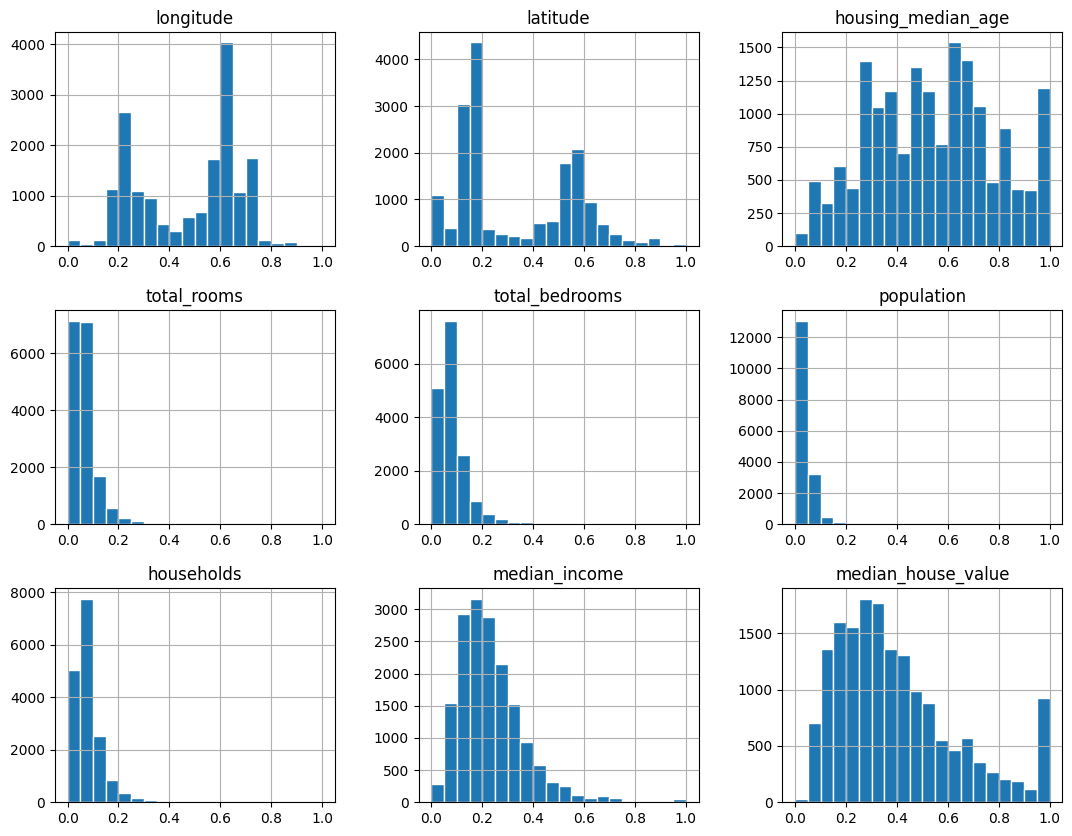

In [169]:
normalized_df.hist(figsize=(13, 10), bins=20, edgecolor="white")

Разделение данных на обучающие и тестовые наборы


In [170]:
import random


def train_test_split_data(x, y, test_ratio=0.2):
    data_length = len(x)
    all_indices = list(range(data_length))
    random.shuffle(all_indices)

    split_point = int(data_length * (1 - test_ratio))

    train_indices = all_indices[:split_point]
    test_indices = all_indices[split_point:]

    X_train = np.array([x[idx] for idx in train_indices])
    X_test = np.array([x[idx] for idx in test_indices])
    y_train = np.array([y[idx] for idx in train_indices])
    y_test = np.array([y[idx] for idx in test_indices])

    return X_train, X_test, y_train, y_test


Реализация линейной регрессии с помощью МНК

In [171]:
X_train, X_test, y_train, y_test = train_test_split_data(df.drop(columns=["median_house_value"]).values,
                                                         df["median_house_value"].values)

In [172]:
class LinearRegression:
    def __init__(self):
        self.beta = None

    def train(self, X, y):
        X = np.column_stack((np.ones(X.shape[0]), X))
        self.beta = inv(X.T @ X) @ X.T @ y

    def score(self, X, y):
        out = self.predict(X)
        return 1 - (np.dot(y - out, y - out)) / (np.dot(y - np.mean(y), y - np.mean(y)))

    def predict(self, X):
        X = np.column_stack((np.ones(X.shape[0]), X))
        return X @ self.beta

Метод score оценивает качество модели с использованием коэффициента детерминации 

In [173]:
rg = LinearRegression()

In [174]:
y = normalized_df["median_house_value"].values
x = normalized_df.drop(columns=["longitude", "latitude", "median_house_value"]).values
X_train, X_test, y_train, y_test = train_test_split_data(x, y)

In [175]:
rg.train(X_train, y_train)
rg.score(X_test, y_test)

np.float64(0.5504429882962851)

In [176]:
y = normalized_df["median_house_value"].values
x = normalized_df.drop(columns=["total_rooms", "total_bedrooms", "median_house_value"]).values
X_train, X_test, y_train, y_test = train_test_split_data(x, y)

rg.train(X_train, y_train)
rg.score(X_test, y_test)

np.float64(0.6495167881183471)

In [177]:
correlation = df['total_rooms'].corr(df['total_bedrooms'])
print(correlation)

0.9284029878168503


Сильная положительная корреляция - что может быть причиной мультиколлинеарности.

Фактор инфляции дисперсии (VIF) используется для измерения степени мультиколлинеарности: при значении большем, чем 10 переменная подвержена мультиколлинеарности. 

In [178]:
vif = 1 / (1 - correlation * correlation)
print(vif)

7.2428135461003835


Полученное значение очень близко к значению VIF, склонному к мультиколлинеарности, поэтому использование обеих независимых параметров при обучении модели не рекоммендуется, хотя значение коэффициента детерминации может быть удовлетворительным.

In [179]:
y = normalized_df["median_house_value"].values
x = normalized_df.drop(columns=["population", "housing_median_age", "median_house_value"]).values
X_train, X_test, y_train, y_test = train_test_split_data(x, y)

rg.train(X_train, y_train)
rg.score(X_test, y_test)

np.float64(0.6156901092610527)

In [180]:
y = normalized_df["median_income"].values
x = normalized_df.drop(columns=["population", "median_house_value", "total_rooms", "median_income"]).values
X_train, X_test, y_train, y_test = train_test_split_data(x, y)

rg.train(X_train, y_train)
rg.score(X_test, y_test)

np.float64(0.0967660362373145)

Получен низкий коэффициент детерминации, что может означать о некорректной выборке независимых параметров.

Дополнительное задание: cинтетический признак 

Введем синтатический признак для полей total_rooms и population для уменьшения влияния мультиколлинеарности. Этот признак может быть полезен, так как он учитывает плотность заселения, что потенциально влияет на цену недвижимости.

In [184]:
df['rooms_per_person'] = df['total_rooms'] / df['population']

In [182]:
normalized_df['rooms_per_person'] = df['total_rooms'] / df['population']

y = normalized_df["median_income"].values
x = normalized_df.drop(columns=["rooms_per_person", "median_house_value", "median_income"]).values
X_train, X_test, y_train, y_test = train_test_split_data(x, y)

rg.train(X_train, y_train)
rg.score(X_test, y_test)

np.float64(0.4497424124436519)

Значение  коэффициента детерминации значительно выросло при добавлении синтетического признака (0.09676 -> 0.44974)